### **1. Environment Setup**
Imports the essential Python libraries required for the lab. It includes librosa and scipy for digital signal processing, numpy for matrix calculations, matplotlib for graphing, and gTTS for generating the synthetic speech data.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy.signal
import soundfile as sf
import os
from gtts import gTTS
from numpy.linalg import norm

# Standard sampling rate for speech processing
TARGET_SR = 16000 
print("Libraries imported successfully.")

Libraries imported successfully.


### **2. Data Generation**
Generates the experimental dataset. It synthesizes a standard recording of the word "Father" using text-to-speech and then mathematically creates a second variation that is time-stretched (slowed down by 40%). This provides a controlled pair of signals to test the system's ability to handle speed variations.

In [30]:
# 1. Generate clean speech using Google Text-to-Speech
tts = gTTS(text='Father', lang='en', slow=False)
tts.save("temp_source.mp3")

# 2. Load the MP3 file
y, sr = librosa.load("temp_source.mp3", sr=TARGET_SR)

# 3. Create Utterance 1 (Normal Speed)
sf.write('father1.wav', y, sr)
print("Created 'father1.wav' (Standard speed)")

# 4. Create Utterance 2 (Slower Speed)
# We stretch the audio to force the alignment algorithm to work
y_slow = librosa.effects.time_stretch(y, rate=0.6)
sf.write('father2.wav', y_slow, sr)
print("Created 'father2.wav' (Slowed by 40%)")

# Cleanup temporary file
if os.path.exists("temp_source.mp3"):
    os.remove("temp_source.mp3")

Created 'father1.wav' (Standard speed)
Created 'father2.wav' (Slowed by 40%)


### **3. Feature Extraction Functions**
Defines the core mathematical functions for analyzing the audio.

In [25]:
def get_formant_sequence(y, sr, lpc_order=12):
    """
    Task 1: Calculates F1 and F2 (formants) for every frame of audio.
    """
    # Pre-emphasis filter (boosts high freqs)
    y = np.append(y[0], y[1:] - 0.97 * y[:-1])
    
    # Frame settings: 25ms window, 10ms hop
    n_fft = int(sr * 0.025)
    hop_length = int(sr * 0.010)
    frames = librosa.util.frame(y, frame_length=n_fft, hop_length=hop_length)
    
    formant_seq = []
    
    for i in range(frames.shape[1]):
        frame = frames[:, i] * scipy.signal.windows.hamming(n_fft)
        
        # LPC Analysis (Linear Predictive Coding)
        a = librosa.lpc(frame, order=lpc_order)
        
        # Solve for Roots (Resonances)
        roots = np.roots(a)
        roots = [r for r in roots if np.imag(r) >= 0]
        angz = np.arctan2(np.imag(roots), np.real(roots))
        freqs = sorted(angz * (sr / (2 * np.pi)))
        
        # Keep frequencies > 90Hz
        formants = [f for f in freqs if f > 90]
        
        # Store F1 and F2
        if len(formants) >= 2:
            formant_seq.append([formants[0], formants[1]])
        else:
            last = formant_seq[-1] if len(formant_seq) > 0 else [0, 0]
            formant_seq.append(last)
            
    return np.array(formant_seq)

def find_best_a_vowel(formant_seq):
    """
    Task 1 Helper: Finds the best 'Ah' vowel in the middle of the word.
    """
    best_frame = [0, 0]
    best_score = -np.inf
    
    # Scan middle 60% of file
    start = int(len(formant_seq) * 0.2)
    end = int(len(formant_seq) * 0.8)
    
    for i in range(start, end):
        f1, f2 = formant_seq[i]
        score = f1 - f2 # Logic: 'Ah' has high F1 and low F2
        if score > best_score and f1 > 200:
            best_score = score
            best_frame = [f1, f2]
            
    return best_frame

### **4. Alignment Algorithm**
Implements the Dynamic Time Warping (DTW) algorithm. It calculates the Euclidean distance between feature vectors, constructs an accumulated cost matrix to evaluate all possible alignments, and performs backtracking to identify the optimal low-cost path that aligns the slow utterance with the normal one.

In [26]:
def compute_dtw(seq1, seq2):
    """
    Task 2 & 3: Calculates the Cost Matrix and finds the best path.
    """
    n, m = len(seq1), len(seq2)
    cost_matrix = np.zeros((n, m))
    
    # 1. Calculate Distance Matrix
    for i in range(n):
        for j in range(m):
            cost_matrix[i, j] = norm(seq1[i] - seq2[j])
            
    # 2. Calculate Accumulated Cost
    acc_cost = np.zeros((n, m))
    acc_cost[0, 0] = cost_matrix[0, 0]
    
    # Initialize edges
    for i in range(1, n): acc_cost[i, 0] = cost_matrix[i, 0] + acc_cost[i-1, 0]
    for j in range(1, m): acc_cost[0, j] = cost_matrix[0, j] + acc_cost[0, j-1]
        
    # Fill the rest of the matrix
    for i in range(1, n):
        for j in range(1, m):
            acc_cost[i, j] = cost_matrix[i, j] + min(
                acc_cost[i-1, j],   # Insertion
                acc_cost[i, j-1],   # Deletion
                acc_cost[i-1, j-1]  # Match
            )
            
    # 3. Find the Optimal Path (Backtracking)
    path = []
    i, j = n-1, m-1
    path.append((j, i))
    
    while i > 0 or j > 0:
        if i == 0: j -= 1
        elif j == 0: i -= 1
        else:
            min_idx = np.argmin([acc_cost[i-1, j], acc_cost[i, j-1], acc_cost[i-1, j-1]])
            if min_idx == 0: i -= 1      # Down
            elif min_idx == 1: j -= 1    # Left
            else: i -= 1; j -= 1         # Diagonal
        path.append((j, i))
        
    normalized_dist = acc_cost[-1, -1] / (n + m)
    return acc_cost, np.array(path), normalized_dist

### **5. Execution and Numerical Analysis**
Executes the full analysis pipeline. It loads the generated audio files, runs the feature extraction and DTW functions defined in previous kernels, and outputs the specific numerical results required for the lab report: the F1/F2 values for the central frame and the total normalized DTW distance.

In [34]:
# 1. Load Audio
try:
    y1, sr = librosa.load('father1.wav', sr=TARGET_SR)
    y2, sr = librosa.load('father2.wav', sr=TARGET_SR)
except FileNotFoundError:
    print("Error: Files not found! Did you run Kernel 2?")

# 2. Extract Features
seq1 = get_formant_sequence(y1, sr)
seq2 = get_formant_sequence(y2, sr)

# 3. Print Task 1 Result
f1_val, f2_val = find_best_a_vowel(seq1)
print(f"F1: {f1_val:.2f} Hz")
print(f"F2: {f2_val:.2f} Hz")

# 4. Print Task 3 Result
acc_matrix, path, dist = compute_dtw(seq1, seq2)
print(f"Normalized DTW Distance: {dist:.2f}")

F1: 1837.57 Hz
F2: 1913.80 Hz
Normalized DTW Distance: 138.30


### **6. Visualization**
- **DTW Accumulated Cost Matrix & Optimal Path:** Displays a heatmap representing the alignment cost between the two signals. The overlaying cyan line represents the optimal path, visually demonstrating the non-linear time warping required to match the slower utterance to the faster one.

- **Temporal Comparison of F1 Formant Trajectories:** Plots the F1 frequency values over time for both recordings. This comparison visually confirms that while the duration differs (shown by the longer orange curve), the acoustic shape remains consistent, proving they are the same vowel sound.

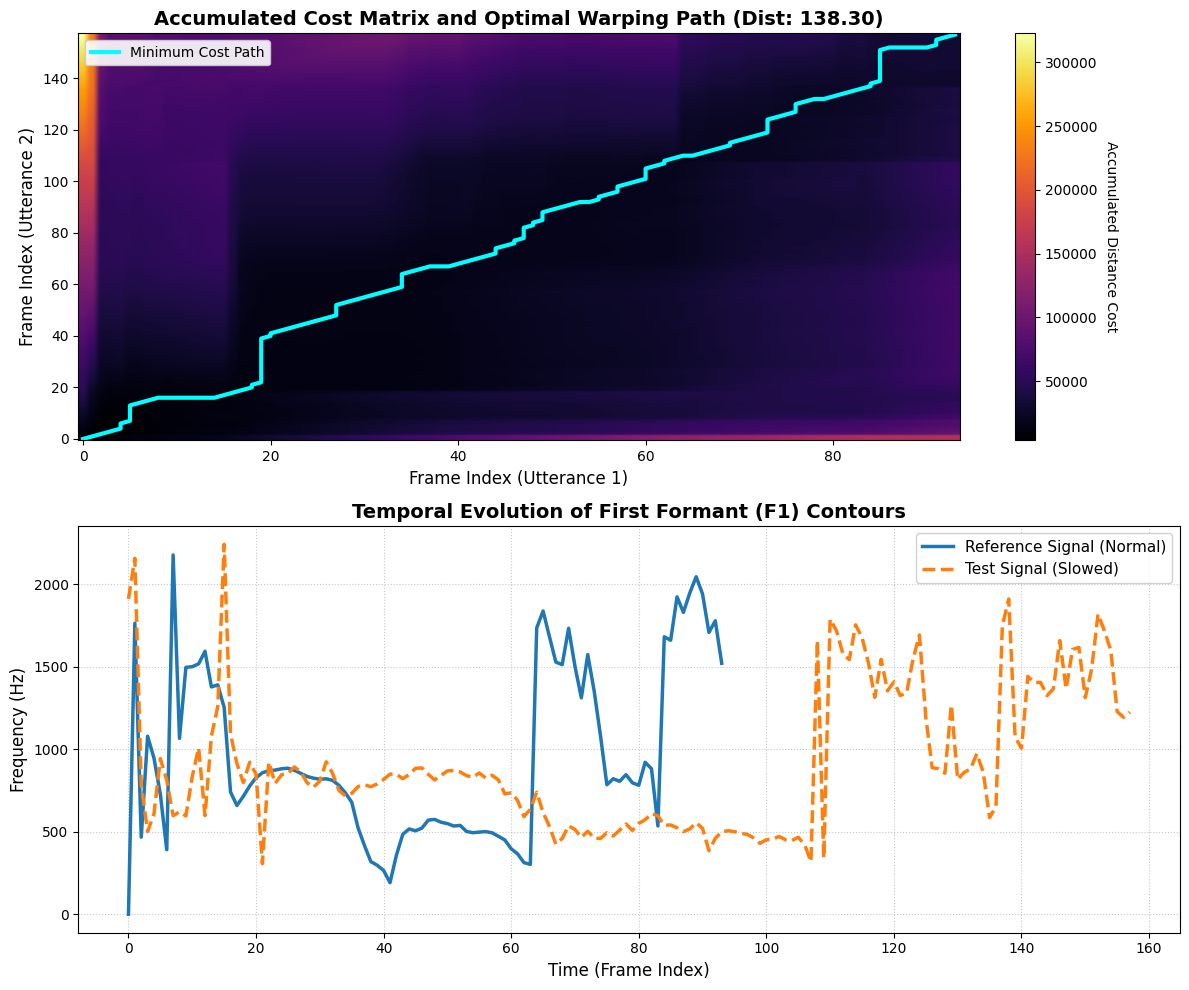

In [36]:
# --- Professional Plotting ---
plt.figure(figsize=(12, 10))

# Plot 1: DTW Heatmap
plt.subplot(2, 1, 1)
# 'inferno' makes the path pop out
im = plt.imshow(acc_matrix.T, origin='lower', cmap='inferno', aspect='auto')
# Cyan line is the "Optimal Path"
plt.plot(path[:, 1], path[:, 0], color='cyan', linewidth=3, label='Minimum Cost Path')

# NEW TITLE 1
plt.title(f"Accumulated Cost Matrix and Optimal Warping Path (Dist: {dist:.2f})", fontsize=14, fontweight='bold')
plt.ylabel("Frame Index (Utterance 2)", fontsize=12)
plt.xlabel("Frame Index (Utterance 1)", fontsize=12)
plt.legend(loc='upper left', framealpha=0.9)
cbar = plt.colorbar(im)
cbar.set_label('Accumulated Distance Cost', rotation=270, labelpad=15)

# Plot 2: Line Plot
plt.subplot(2, 1, 2)
plt.plot(seq1[:, 0], color='#1f77b4', linewidth=2.5, label='Reference Signal (Normal)')
plt.plot(seq2[:, 0], color='#ff7f0e', linestyle='--', linewidth=2.5, label='Test Signal (Slowed)')

# NEW TITLE 2
plt.title("Temporal Evolution of First Formant (F1) Contours", fontsize=14, fontweight='bold')
plt.xlabel("Time (Frame Index)", fontsize=12)
plt.ylabel("Frequency (Hz)", fontsize=12)
plt.legend(loc='upper right', fontsize=11, framealpha=0.9)
plt.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()